# 기계학습 Project
# name: 황인선
# ID: 2020010437

## Task Description: Given train dataset “train_data.csv”, find the best model for the below task

### A. Input Features: Morphological phenotypes

i. Colum D-BU (ST***CV) : Cortical Volume of 70 brain regions

ii. Colum BV-EM (ST***TA) : Average Thickness of 70 brain regions

iii. Beware of missing features

### B. Task (3-logit Regression): Predict the cognitive assessment scores of subjects for test dataset “sample_evaluation_data.csv”

i. Colum A (ADAS11): Alzheimer's Disease Assessment Scale (11 questions version)

ii. Colum B (ADAS13): Alzheimer's Disease Assessment Scale (13 questions version)

iii. Colum C (MMSE): Mini-Mental State Examination

## Project Requirement
A. Perform Bayesian linear regression based on the given train dataset “train_data.csv”

i. Any form of basis function is allowed

B. Do Bayesian model selection

C. Analyze and discuss your models and results in markdown cells

D. No use of library for Bayesian inference is allowed

E. TAs will assess your model with a test dataset, and grade your project  accordingly

## Reference

Pattern Recognition and Machine Learning(Christopher Bishop)

https://github.com/fmfn/BayesianOptimization

https://github.com/zjost/bayesian-linear-regression/blob/master/src/bayes-regression.ipynb

https://github.com/kumar-shridhar/PyTorch-BayesianCNN


In [1]:
from __future__ import print_function
import os
import sys
sys.path.append("..")
import argparse

import numpy as np
import pandas as pd
import csv

from sklearn.preprocessing import normalize
from sklearn.preprocessing import RobustScaler
import random

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader

# Data Loader

In [2]:
def read_make_set(dataset_path):

    data_set = list()
    with open(dataset_path, newline='') as csvfile:
        line_reader = csv.reader(csvfile, delimiter=',')
        one_set = list()
        for element in line_reader:
            line_list = list()
            for ele in element:
                if ele == "": # 빈칸일 경우
                    ele = 0
                line_list.append(ele)
            one_set.append(line_list)
        data_set.append(one_set)
    data_set = np.concatenate(data_set, axis=0)

    return data_set


class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path):

        data_set = read_make_set(dataset_path) 
        random.seed(1234)
        random.shuffle(data_set[1:,:])

        data = data_set[1:, 3:].astype(np.float32)
        target = data_set[1:, :3].astype(np.float32)
        
        # normalize
        # data_normed = data / data.max(axis=0)
        # data = normalize(data, axis=0, norm='max')
        # https://mkjjo.github.io/python/2019/01/10/scaler.html
        robustScaler = RobustScaler()
        print(robustScaler.fit(data))
        data = robustScaler.transform(data)
        
        
        self.data = torch.FloatTensor(data)
        self.target = torch.FloatTensor(target)

    def __getitem__(self, index):

        return self.data[index], self.target[index]

    def __len__(self):

        return self.data.size(0)

def myCollate(batch):

    data = torch.stack([item[0] for item in batch], 0) # [batch, 140]
    target = torch.stack([item[1] for item in batch], 0) # [batch, 3]

    return [data, target]

def getDataLoader(train_set, validation_set, test_set):
    
    train_loader = DataLoader(train_set, batch_size=96, num_workers=0, collate_fn=myCollate)
    validation_loader = DataLoader(validation_set, batch_size=1, num_workers=0, collate_fn=myCollate)
    test_loader = DataLoader(test_set, batch_size=1, num_workers=0, collate_fn=myCollate)

    return train_loader, validation_loader, test_loader

## Model

In [3]:
class Linear(nn.Module):

    def __init__(self, in_features, out_features, priors):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        self.W_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.W_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features))

        self.reset_parameters()

        self.softplus = nn.Softplus()

    def reset_parameters(self):
        # posterior
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

        self.bias_mu.data.normal_(*self.posterior_mu_initial)
        self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, x, sample=True):
        
        # Weight sampling
        self.W_sigma = torch.log1p(torch.exp(self.W_rho))
        self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        bias_var = self.bias_sigma ** 2

        act_mu = F.linear(x, self.W_mu, self.bias_mu)
        act_var = 1e-16 + F.linear(x ** 2, self.W_sigma ** 2, bias_var)
        act_std = torch.sqrt(act_var)

        loss = self.kl_loss()

        if self.training or sample:
            # sampling된 weight로 값 구하기
            eps = torch.empty(act_mu.size()).normal_(0, 1)
            return act_mu + self.softplus(act_std) * eps, loss
            # return act_mu + act_std * eps, loss
        else:
            return act_mu

    def calculate_kl(self, mu_q, sig_q, mu_p, sig_p):
        
        kl = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()

        return kl

    def kl_loss(self):
        
        kl = self.calculate_kl(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        kl += self.calculate_kl(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)

        return kl

In [4]:
class myModel(nn.Module):
    """
    data: [batch, 140]
    target: [batch, 3]
    """

    def __init__(self, in_dim, out_dim, priors):
        super(myModel, self).__init__()

        self.basis_function = nn.Linear(in_dim, 32)
        torch.nn.init.xavier_uniform_(
            self.basis_function.weight,
            gain=torch.nn.init.calculate_gain('tanh'))
        self.fc_a = Linear(32, 3, priors=priors)
        self.tanh = nn.Tanh()
        
    def forward(self, x):

        basis_output = self.tanh(self.basis_function(x))
        output, loss = self.fc_a(basis_output)

        return output, loss

In [5]:
class ELBO2(nn.Module):
    def __init__(self, train_size):
        super(ELBO2, self).__init__()
        self.train_size = train_size

    def forward(self, samples, target):
        
        assert not target.requires_grad
        
        mse_loss = 0.0
        # 이거는 N개를 샘플링해서 평균을 한다
        for sample in samples:
            mse_loss += torch.nn.MSELoss(reduction='mean')(sample, target) 
        mse_loss /= len(samples)

        return mse_loss

In [6]:
def getModel(in_dim, out_dim, priors):

    return myModel(in_dim, out_dim, priors)

def train_model(model, train_loader, criterion, optimizer):
    
    model.train()
    train_loss, mse_loss, kl_loss = 0.0, 0.0, 0.0
    acc_list, kl_list = list(), list()

    for i, (inputs, labels) in enumerate(train_loader, 1):

        # inputs, labels = inputs.to(device), labels.to(device)
        output, kl_output = model(inputs)
        
        sample_list = [model(inputs) for _ in range(1)]
        output_list = [output for output, kl_output in sample_list]
        kl_output = sample_list[0][1]

        beta = 0.1 # 1/len(train_loader)
        kl = beta * kl_output
        mse = criterion(output_list, labels)        
        loss = mse + kl

        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data.numpy()
        mse_loss += mse
        kl_loss += kl

    return train_loss/len(train_loader), mse_loss/len(train_loader), kl_loss/len(train_loader), output_list[0], labels    

## Main

In [7]:
load_pretrained_model = False

In [10]:
initial_lr = 1e-3
n_epochs = 500

train_dataset_path = 'train_data.csv'
validation_dataset_path = 'validation_data.csv'
test_dataset_path = 'sample_evaluation_data.csv'
checkpoint_path = 'checkpoint' # file name

priors={
    'prior_mu': 0,
    'prior_sigma': 0.2,
    'posterior_mu_initial': (0, 0.2),  # (mean, std) normal_
    'posterior_rho_initial': (0, 0.2),  # (mean, std) normal_
}

model = getModel(in_dim=140, out_dim=3, priors=priors)
train_set = Dataset(train_dataset_path)
validation_set = Dataset(validation_dataset_path)
test_set = Dataset(test_dataset_path)

train_loader, validation_loader, test_loader = getDataLoader(train_set, validation_set, test_set)

criterion = ELBO2(len(train_set))
optimizer = Adam(model.parameters(), lr=initial_lr)
lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=30, verbose=True)

if load_pretrained_model == True:
    state_dict = torch.load(checkpoint_path)['state_dict']
    model.load_state_dict(state_dict)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)


## Data Analysis
### check data features

In [11]:
import pandas as pd

data_set = read_make_set(train_dataset_path) 
data = pd.DataFrame(data_set)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142
0,ADAS11,ADAS13,MMSE,ST102CV,ST103CV,ST104CV,ST105CV,ST106CV,ST107CV,ST108CV,ST109CV,ST110CV,ST111CV,ST113CV,ST114CV,ST115CV,ST116CV,ST117CV,ST118CV,ST119CV,ST121CV,ST123CV,ST129CV,ST130CV,ST13CV,ST14CV,ST15CV,ST23CV,ST24CV,ST25CV,ST26CV,ST31CV,ST32CV,ST34CV,ST35CV,ST36CV,ST38CV,ST39CV,ST40CV,ST43CV,...,ST34TA,ST35TA,ST36TA,ST38TA,ST39TA,ST40TA,ST43TA,ST44TA,ST45TA,ST46TA,ST47TA,ST48TA,ST49TA,ST50TA,ST51TA,ST52TA,ST54TA,ST55TA,ST56TA,ST57TA,ST58TA,ST59TA,ST60TA,ST62TA,ST64TA,ST72TA,ST73TA,ST74TA,ST82TA,ST83TA,ST84TA,ST85TA,ST90TA,ST91TA,ST93TA,ST94TA,ST95TA,ST97TA,ST98TA,ST99TA
1,9,14,27,3295,1760,2957,1975,3270,1871,9504,3219,12683,8167,1956,15106,18296,12517,11914,9771,2024,1221,6627,6245,5844,2361,2161,4782,2116,1757,723,6714,11308,10841,1669,8168,6690,6040,3858,11530,2911,...,2.098,1.965,2.666,1.69,2.328,2.636,2.159,2.354,2.174,2.331,2.335,1.353,1.757,2.27,2.189,2.099,2.695,2.112,2.537,2.004,2.698,2.445,3.461,2.216,1.004,2.48,2.428,2.234,1.67,3.132,2.467,2.424,2.345,2.914,2.461,2.129,2.519,1.606,2.363,2.864
2,5,7,26,3644,1926,4376,2723,4806,1756,10159,2972,13170,10227,1754,14615,18758,12629,9276,10399,2057,842,0,7175,5860,2154,2159,5930,2979,1770,761,10683,10900,11519,2544,10561,7039,6141,4148,9033,3354,...,2.719,2.031,2.429,2.204,2.079,2.852,2.367,2.887,2.543,2.395,2.431,1.712,2.034,2.602,2.598,2.246,2.401,2.142,2.574,2.169,2.877,2.602,3.375,2.382,0,2.657,2.543,2.348,1.948,3.782,2.44,2.843,2.499,2.695,2.457,2.254,2.269,1.868,2.142,2.679
3,16.33,29.33,25,3096,2191,3784,2344,2675,2063,8561,3208,14310,7538,1571,14405,20381,11549,9488,8848,2175,1109,6150,6085,5977,1828,1392,5996,3021,1562,489,8597,6703,8310,2281,11219,7499,7580,4451,7417,3979,...,2.253,1.891,2.54,1.879,2.279,2.548,2.298,2.861,2.528,2.827,2.234,1.404,1.94,2.285,2.436,1.8,2.94,2.152,2.692,1.756,2.607,2.221,3.703,2.175,1.064,2.058,2.168,2.414,1.885,3.303,2.702,2.617,2.108,2.526,2.151,2.003,2.534,1.996,2.163,2.643
4,6,9,29,3857,2660,3382,2751,3783,2202,9074,2504,11995,10484,1986,13690,20896,15095,10463,11313,2787,935,0,7009,7279,1719,2238,5620,2816,1934,925,11194,11349,10076,2299,11054,7071,6329,5498,8785,3696,...,2.643,2.158,2.489,1.952,2.289,2.767,2.199,3.184,2.388,2.671,2.179,1.536,2.137,2.539,2.481,2.376,2.736,2.163,2.638,2.185,2.709,2.328,3.924,2.529,0,2.663,2.99,2.469,1.922,4.232,2.546,2.937,2.514,2.875,2.837,2.379,2.315,1.954,2.326,2.989


## normalize features
** notation: This code works in the data processing section, which is marked for display.

In [12]:
#data_set[1:, :] = normalize(data_set[1:,:], axis=0, norm='max')
robustScaler = RobustScaler()
print(robustScaler.fit(data_set[1:,:]))
data_set = robustScaler.transform(data_set[1:,:])

data = pd.DataFrame(data_set)
data.head()

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142
0,0.00000,-0.073153,-0.333333,-0.136187,-0.252723,-0.499410,-0.550363,-0.132240,-0.183124,0.987973,0.503586,0.636505,-0.013468,0.232406,0.725351,0.025702,0.557425,1.205012,0.547190,0.104228,2.036117,1.039856,0.212064,-0.184200,0.276740,0.792453,-0.459729,-0.593796,-0.015785,0.429864,-1.059690,0.366528,0.571840,-0.977215,-0.933514,0.199351,0.274775,-0.256571,1.143923,-0.131789,...,-0.849850,-0.251685,0.771429,-0.569343,0.125253,-0.149153,-0.058520,-0.326316,-0.870488,-0.578462,0.383562,-0.407960,-0.425263,-0.612903,-0.270655,-0.203704,-0.333333,-0.250000,0.122271,-0.084778,0.638436,0.428571,-0.054902,0.207622,0.974284,0.350263,-0.229346,-0.381308,-0.260465,-0.378031,-0.193634,-0.457870,0.261343,0.666667,0.356932,0.214433,0.213836,-1.092166,0.362235,0.506567
1,-0.50000,-0.585223,-0.666667,0.316472,0.108932,1.175915,1.003115,1.546448,-0.389587,1.363116,0.109960,0.852517,1.053613,-0.098200,0.546382,0.163778,0.603946,-0.201546,0.880170,0.169125,0.325056,0.000000,1.088596,-0.171869,-0.074703,0.789022,0.358517,0.680945,0.004736,0.601810,1.027610,0.204333,0.850565,0.499578,0.145143,0.522949,0.350601,-0.029031,-0.020994,0.509776,...,1.015015,0.044944,-0.195918,1.931873,-0.880808,0.583051,0.657487,0.608772,0.696391,-0.381538,0.759295,1.378109,0.741053,0.725806,0.894587,0.340741,-1.104987,-0.102941,0.283843,0.551060,1.221498,1.003663,-0.223529,0.643890,0.000000,0.970228,0.054254,0.044860,1.032558,0.549215,-0.265252,0.874404,0.820327,-0.078231,0.345133,0.729897,-0.834382,0.115207,-0.489403,-0.187617
2,0.91625,1.048281,-1.000000,-0.394293,0.686275,0.476978,0.215992,-0.782514,0.161580,0.447881,0.486056,1.358173,-0.339290,-0.397709,0.469838,0.648834,0.155348,-0.088510,0.057794,0.401180,1.530474,0.965009,0.061263,-0.081696,-0.628183,-0.526587,0.405560,0.742984,-0.323599,-0.628959,-0.069419,-1.464122,-0.468654,0.055696,0.441740,0.949467,1.430931,0.208709,-0.774901,1.414917,...,-0.384384,-0.584270,0.257143,0.350365,-0.072727,-0.447458,0.419966,0.563158,0.632696,0.947692,-0.011742,-0.154229,0.345263,-0.552419,0.433048,-1.311111,0.309711,-0.053922,0.799127,-1.040462,0.342020,-0.391941,0.419608,0.099869,1.032508,-1.127846,-0.870530,0.291589,0.739535,-0.134094,0.429708,0.155803,-0.598911,-0.653061,-0.557522,-0.305155,0.276730,0.705069,-0.408478,-0.322702
3,-0.37500,-0.438917,0.333333,0.592737,1.708061,0.002361,1.061267,0.428415,0.411131,0.741695,-0.635857,0.331337,1.186739,0.281506,0.209222,0.802750,1.628245,0.431352,1.364793,1.604720,0.744921,0.000000,0.932139,0.921773,-0.813243,0.924528,0.137562,0.440177,0.263615,1.343891,1.296345,0.382826,0.257348,0.086076,0.367365,0.552619,0.491742,1.030208,-0.136692,1.005069,...,0.786787,0.615730,0.048980,0.705596,-0.032323,0.294915,0.079174,1.129825,0.038217,0.467692,-0.227006,0.502488,1.174737,0.471774,0.561254,0.822222,-0.225722,0.000000,0.563319,0.612717,0.674267,0.000000,0.852941,1.030223,0.000000,0.991243,1.156597,0.497196,0.911628,1.191155,0.015915,1.173291,0.874773,0.534014,1.466077,1.245361,-0.641509,0.511521,0.219653,0.975610
4,-0.50000,-0.512070,0.000000,0.014267,-0.649237,-0.845336,0.400831,0.062295,-0.759425,-0.372852,-0.642231,-0.641827,-0.238798,-0.594108,-0.024057,-0.127017,-0.296989,-0.664889,-0.088017,-0.037365,0.469526,0.000000,-0.702168,-0.037765,-0.217317,-0.504288,-1.308624,-0.404727,-1.037096,0.108597,0.458585,-0.167760,-0.457143,-0.318987,-0.677936,-0.861382,0.138889,0.231463,-0.147422,-0.128892,...,0.789790,0.480899,0.918367,1.255474,1.212121,0.657627,0.361446,-0.722807,1.316348,1.341538,0.520548,0.502488,0.555789,0.495968,0.669516,0.488889,0.044619,1.627451,1.323144,0.300578,0.488599,0.809524,-0.752941,0.664915,0.000000,0.360771,-0.345253,0.605607,1.186047,-0.094151,1.098143,0.817170,0.606171,0.442177,0.315634,0.73

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

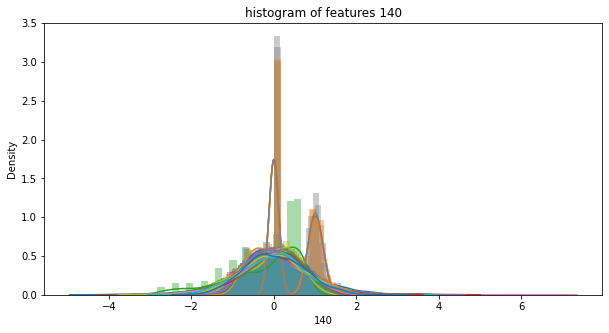

In [13]:
plt.figure(figsize=(10, 5))
for cnt, col in enumerate(data):
    try:        
        sns.distplot(data[cnt])
        if cnt >= 140: 
            break
    except Exception as e:
        pass
plt.title('histogram of features '+str(col))
plt.show()

### split train and validation set

In [14]:
print("train_set:", len(train_set))
print("validation_set:", len(validation_set))

train_set: 1447
validation_set: 160


## Training

In [ ]:
# valid_loss_max = np.Inf

# print("train start! -------------------------------------------------------------------")
# for epoch in range(n_epochs):
    
#     model.train()
#     train_loss, train_mse, train_kl, train_output, train_labels = train_model(
#         model, train_loader, criterion, optimizer)


#     print('[training] Epoch: {} \tTotal: {:.2f} \tMSE: {:.2f} \tKL: {:.2f} \toutput: {:.2f} {:.2f} {:.2f} \tlabel: {:.2f} {:.2f} {:.2f}'.format(
#         epoch, train_loss, train_mse, train_kl, 
#         train_output[0][0], train_output[0][1], train_output[0][2], 
#         train_labels[0][0], train_labels[0][1], train_labels[0][2]))
    
#     #if epoch % 100 == 0:            
#     model.eval()
#     valid_loss, valid_mse, valid_kl, valid_output, valid_labels = train_model(
#         model, validation_loader, criterion, optimizer)
#     lr_sched.step(valid_loss)

#     # print('\n\n[validation] \tTotal: {:.2f} \tMSE: {:.2f} \tKL: {:.2f} \toutput: {:.2f} {:.2f} {:.2f} \tlabel: {:.2f} {:.2f} {:.2f}'.format(
#     #     valid_loss, valid_mse, valid_kl, 
#     #     valid_output[0], valid_output[1], valid_output[2], 
#     #     valid_labels[0], valid_labels[1], valid_labels[2]))

#     # save model if validation accuracy has increased
#     if valid_loss < valid_loss_max:
#         print('Validation loss decreased ({:.2f} --> {:.2f}).  Saving model ...'.format(
#             valid_loss_max, valid_loss))
#         torch.save({'state_dict': model.state_dict(),
#             'optimizer': optimizer.state_dict()}, 'checkpoint')
#         valid_loss_max = valid_loss

# print("train end! -------------------------------------------------------------------")

train start! -------------------------------------------------------------------
[training] Epoch: 0 	Total: 426.73 	MSE: 418.78 	KL: 7.96 	output: 0.78 -2.94 2.38 	label: 3.00 5.00 30.00
Validation loss decreased (inf --> 395.20).  Saving model ...
[training] Epoch: 1 	Total: 394.45 	MSE: 386.92 	KL: 7.54 	output: 1.56 -9.16 -2.96 	label: 3.00 5.00 30.00
Validation loss decreased (395.20 --> 231.66).  Saving model ...
[training] Epoch: 2 	Total: 408.95 	MSE: 396.65 	KL: 12.30 	output: -9.75 -6.78 -13.70 	label: 3.00 5.00 30.00
Validation loss decreased (231.66 --> 132.80).  Saving model ...
[training] Epoch: 3 	Total: 445.76 	MSE: 422.80 	KL: 22.96 	output: -9.95 -12.02 -15.19 	label: 3.00 5.00 30.00
Validation loss decreased (132.80 --> 92.33).  Saving model ...
[training] Epoch: 4 	Total: 436.46 	MSE: 408.39 	KL: 28.07 	output: -9.46 -17.61 -21.56 	label: 3.00 5.00 30.00
Validation loss decreased (92.33 --> 79.35).  Saving model ...
[training] Epoch: 5 	Total: 406.55 	MSE: 379.88 	K

## Visualization

In [15]:
model = getModel(in_dim=140, out_dim=3, priors=priors)
state_dict = torch.load(checkpoint_path)['state_dict']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [16]:
outputs = list()
for i, (inputs, _) in enumerate(validation_loader, 1): 
    model.eval()
    # output, kl_output = model(inputs)
    # 10번 sampling한 결과를 평균해서 사용한다
    sample_list = [model(inputs) for _ in range(10)]
    
    output_list = [output.detach().cpu()[0] for output, kl_output in sample_list] # ex: [tensor([ 8.9365, 16.9758, 29.5531]), ..., tensor([10.1473, 18.4413, 29.4108])]
    x = [x.detach().cpu().numpy() for x, y, z in output_list]
    y = [y.detach().cpu().numpy() for x, y, z in output_list]
    z = [z.detach().cpu().numpy() for x, y, z in output_list]
    x = np.mean(x)
    y = np.mean(y)
    z = np.mean(z)
    output = np.stack([x, y, z])
    outputs.append([inputs.detach().cpu().numpy(), output, _.detach().cpu().numpy()]) # 원래 데이터 x, bayesian결과 output, target label y
    
output = [output_ for input_, output_, label_ in outputs] # [batch, 3]
target = [label_ for input_, output_, label_ in outputs] # 혹시 제공된다면 저장됨(안되면 0으로 저장됨)
input = [input_ for input_, output_, label_ in outputs]

output = np.stack(output, axis=0) # [batch, 3]
target = np.concatenate(target, axis=0) # [10, 3]
input = np.concatenate(input, axis=0) # [10, 140]

## Figure 1. Prediction 'ADAS11' at validation set

Text(0, 0.5, 'target y')

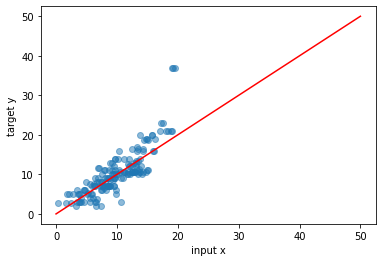

In [17]:
plt.plot([0, 50], [0, 50], 'r')
plt.scatter(output[:,0], target[:,0], alpha=0.5)
plt.xlabel('input x')
plt.ylabel('target y')

## Figure 2. Prediction 'ADAS13'  at validation set

Text(0, 0.5, 'target y')

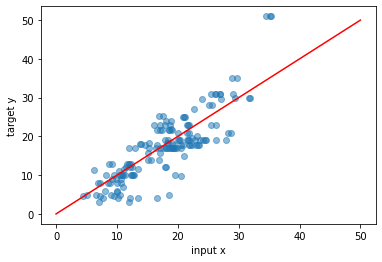

In [18]:
plt.plot([0, 50], [0, 50], 'r')
plt.scatter(output[:,1], target[:,1], alpha=0.5)
plt.xlabel('input x')
plt.ylabel('target y')

## Figure 3. Prediction 'MMSE'  at validation set

Text(0, 0.5, 'target y')

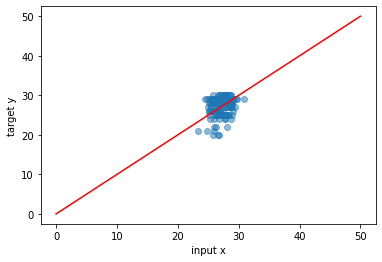

In [19]:
plt.plot([0, 50], [0, 50], 'r')
plt.scatter(output[:,2], target[:,2], alpha=0.5)
plt.xlabel('input x')
plt.ylabel('target y')

## Design
Assume the target $t$ is given by some function of the inputs/parameters plus a noise term.

$$t = f(\vec{x}, \vec{w}) + \epsilon $$

Let's assume the noise is characterized by a normal distribution of mean 0 and precision $\beta$.  Therefore we can say the probability of a value $t$ is given by a normal distribution around the value of the function $f(\vec{x}, \vec{w})$ at that point:

$$p(t \mid \vec{x}, \vec{w}) = Norm(t \mid f(\vec{x}, \vec{w}), \beta^{-1}) \tag{1}$$ 

where $Norm(t \mid \mu, \sigma^2)$ represents a normal distribution of mean $\mu$ and variance $\sigma^2$.

Ultimately, we want to be able to predict $t$ for a new input $\vec{x}$ given some old data $D$ to base that prediction on: 

$$p(t \mid \vec{x}, D)$$

Our Bayesian treatment will allow us to assign this **probability to each value of $t$** for a given $\vec{x}$.  Note that this is more powerful than merely assigning a single-valued estimate of $t$ like traditional Linear Regression, because the probability distribution allows us to assess our *uncertainty in our estimate*, or "model uncertainty".  If we need an estimate for $t$ we can simply choose the maximum of this probability distribution.

Let's assume a model for this target that's linear in the parameters $\{w_j\}$, but has a general basis representation of the inputs given by $\{\phi_j(\vec{x})\}$.  This results in the following model form:
$$y(\vec{x}, \vec{w}) = w_0 + \sum_{j=1}^{M-1} w_j\phi_j(\vec{x})$$ 
where M is the total number of model parameters.

Note that the basis functions $\phi_j(\vec{x})$ do *not* need to be linear in $\vec{x}$; the linearity required in the assumptions is in reference to the parameters $\{w_j\}$.  We could therefore have, e.g. $\phi_n(x) = sin(nx)$.

For convenience, let's define the basis function $\phi_0(\vec{x}) \equiv 1$ so that we can write the model as a vector equation: 

$$y(\vec{x}, \vec{w}) = \vec{w}^T \vec{\phi}(\vec{x})$$

where $\vec{\phi} = (\phi_0, ..., \phi_{M-1})^T$ and $\vec{w} = (w_0, ..., w_{M-1})^T$

Therefore our model of the target $t$ is given by:

$$p(t \mid \vec{x}, \vec{w}) =  Norm(t \mid y(\vec{x}, \vec{w}), \beta^{-1}) = Norm(t \mid \vec{w}^T \vec{\phi}(\vec{x}), \beta^{-1}) \tag{2}$$ 

and we hope, among other things, to find values for $\vec{w}$ that make a good fit to the true model, given by $(1)$.

## Setting model & Analysis
1. Because the scale of input data's value is different for each feature.
  
  1-a. FIrst. I used normalize between 0 and 1 for each feature, howerver the abnormal values did not scale well, and the values in the middle were clumped together, so it did not scale well.
  
  1-b. Second. Robust scaling was more effective in learning than min-max scaling because it did scaling for intermediate values and ignored anomalies.

2. Initial setting both prior and prior to $N(0, 0.2)$ rather than $N(0, 1)$. Setting the variance to 0.2 was better than setting it to 1, but the accuracy was higher probably because we learned to extract samplings in a narrower range.

3. Setting basis function $\vec{\phi}$ is linear transformation from 140 to 32 dimension to extract Alzheimer's Disease features and then input bayesian linear layer for training mu and sigma of prior and posterior. 
  
  reason why setting 32 dimension. better performance was not exhibited when setting a value of 32 or more. The reason may be that it is difficult to mapping  information. Also, the dimension is higher than necessary and it may be difficult to predict distribution.

4. I compare prediction with target value to using plotting utils. Look at the Figure1, Figure2, Figure3. In the plot, the x-axis is the input value, x, and the y-axis is the predicted y-value. And the better the model predicts, the farther it is near the red line, and the worse it is, the farther it is.
Although the model predicted the target value well, the MSE Loss is between 50 and 60 and seems to have a large variation.

## Discuss
There is some difficult beacause example of lecture is assumm that real function that is $a_0$ is -0.3 and $a_1$ is 0.5. and input x is transformation by linear basis function.

My first attemp is find out linear function to use basis function. this result is very fool to predict values because linear function cannot transform 140 dimension's features.

Second attemp is using deep learning to to find out both basis function and bayesian linear model at the same time.


## Result
Through deep learning, I have implemented a model that learns basic function and prior and posterior of Bayesian linear model. I found it difficult to implement as stated in the formula.
And because the amount of data is not large enough and the dimension is large, there is a problem of overfitting easily. However, I improved this problem by dividing dataset into train and validation set.
I also found that the Bayesian model must be properly set up for basis function. Finally, it was difficult to learn prior and posterior distribution because the amount of data is small, and each feature has a different variation. This part is likely to be resolved if the amount of data is sufficient.
In conclusion, by extracting the features of the given data with Bayesian linear model, and obtaining distribution, the data's uncertainty was solved to help predict a more accurate result.

## Bayesian Regression(Test set)
test dataset의 주소를 'sample_evaluation_data.csv'로 설정하고 실행해주세요.
output 변수에 결과가 저장되어 있습니다.

In [20]:
test_dataset_path = 'sample_evaluation_data.csv'

model = getModel(in_dim=140, out_dim=3, priors=priors)

checkpoint_path = 'checkpoint'
state_dict = torch.load(checkpoint_path)['state_dict']
model.load_state_dict(state_dict)

test_set = Dataset(test_dataset_path)
_, _, test_loader = getDataLoader(test_set, test_set, test_set)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)


In [21]:
outputs = list()
for i, (inputs, _) in enumerate(test_loader, 1): 
    model.eval()
    # output, kl_output = model(inputs)
    # 10번 sampling한 결과를 평균해서 사용한다
    sample_list = [model(inputs) for _ in range(10)]
    output_list = [output for output, kl_output in sample_list]
    x = torch.FloatTensor([output.squeeze(0)[0] for output in output_list]).mean() #/ len(output_list)
    y = torch.FloatTensor([output.squeeze(0)[1] for output in output_list]).mean()
    z = torch.FloatTensor([output.squeeze(0)[2] for output in output_list]).mean()

    output_concat = torch.stack([x, y, z])
    outputs.append([inputs.detach().cpu().numpy(), output_concat.detach().cpu().numpy(), _.detach().cpu().numpy()]) # 원래 데이터 x, bayesian결과 output, target label y
    
output = [output_ for input_, output_, label_ in outputs] # [batch, 3]
target = [label_ for input_, output_, label_ in outputs] # 혹시 제공된다면 저장됨(안되면 0으로 저장됨)
input = [input_ for input_, output_, label_ in outputs]

output = np.stack(output, axis=0) # [batch, 3]
target = np.concatenate(target, axis=0) # [10, 3]
input = np.concatenate(input, axis=0) # [10, 140]

In [22]:
print(output)

[[17.473911  17.690258  27.149023 ]
 [ 6.4289064 16.279245  26.883533 ]
 [18.729614  17.96076   26.62522  ]
 [17.68887   16.52379   27.816168 ]
 [18.384045  17.286093  27.791946 ]
 [ 1.1827693 19.89408   27.726496 ]
 [19.623264  18.080555  26.059402 ]
 [17.820692  20.797432  26.35087  ]
 [ 8.28266   14.353781  27.886007 ]
 [ 4.012786  19.189014  28.494131 ]]
